## Setup stuff

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate
from pynq import PL
PL.reset()
import xrfdc
from pynq import Overlay
ol = Overlay('./final.bit')
# sanity check that we are at 150 MHz
from pynq import Clocks
Clocks.pl_clk0_mhz = 150
print(Clocks.pl_clk0_mhz)

150


In [27]:
rf = ol.usp_rf_data_converter_0
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 1575.43
doppler = 0
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1000 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'Freq': 1575.429999999993, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [28]:
N = 4096
num_width = 32

In [29]:
mmio_interface = ol.mmio_interface
dma_output = ol.axi_dma_0
dma_prn_config = ol.axi_prn_config
dma_iq_config = ol.axi_iq_config
dma_ifft_config = ol.axi_ifft_config

In [30]:
# set up ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1
# note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

## Functions

In [31]:
# numerical helpers
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [32]:
import time
def get_conv_data(): #outputs 1 code block
    mmio_interface.write(0x08, 0)
    res_data = allocate(2*N, dtype=np.uint32)
    time.sleep(0.0005)
    mmio_interface.write(0x08, 1)
    dma_output.recvchannel.transfer(res_data)
    dma_output.recvchannel.wait()
    return res_data

In [33]:
def doppler_sweep(prn_id, start = -8000, end = 8000, step = 100, scaling = 16): #sweeps frequency range
    doppler_range = list(range(start, end, step))
    mmio_interface.write(0x00, scaling)
    mmio_interface.write(0x04, prn_id-1)

    amplitudes = []
    for doppler in doppler_range:
        
#         if doppler % 1000 == 0: print(f'on doppler {doppler}')
            
        # set adc frequency now
        adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
        adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
        
        res_data = get_conv_data()

        # now do calculation
        real = res_data[1::2]
        imag = res_data[0::2]
        real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
        imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]
        convolve = np.array([x+y*1j for (x,y) in zip(real_decimal, imag_decimal)])
        peak_position = np.argmax(abs(convolve))
        amplitudes.append(abs(convolve)[peak_position]**2)

    plt.plot(doppler_range, amplitudes)
    best_doppler = np.argmax(amplitudes)
    return amplitudes

In [34]:
#doppler_sweep(2)

In [35]:
max_amplitudes = {}
def prn_sweep(start = -5000, end = 5000, step = 100, scaling = 16): #sweeps all 37 prns
    full_data = []
    for i in range(1,38):
        amplitudes = doppler_sweep(i,start=start, end=end, step=step, scaling=scaling)
        full_data.append(amplitudes)
        print(f"Frequency sweep of prn ID {i}, max {max(amplitudes)}") 
        max_amplitudes[i] = max(amplitudes)
    return full_data

Frequency sweep of prn ID 1, max 44884512.0
Frequency sweep of prn ID 2, max 40952201.0
Frequency sweep of prn ID 3, max 43616050.0
Frequency sweep of prn ID 4, max 45482584.99999999
Frequency sweep of prn ID 5, max 65621241.99999999
Frequency sweep of prn ID 6, max 56424504.99999998
Frequency sweep of prn ID 7, max 40508916.99999999
Frequency sweep of prn ID 8, max 41485153.99999999
Frequency sweep of prn ID 9, max 44390580.99999999
Frequency sweep of prn ID 10, max 33179770.000000004
Frequency sweep of prn ID 11, max 110641540.00000003
Frequency sweep of prn ID 12, max 46858025.0
Frequency sweep of prn ID 13, max 42455289.99999999
Frequency sweep of prn ID 14, max 39127049.99999999
Frequency sweep of prn ID 15, max 42067037.00000001
Frequency sweep of prn ID 16, max 44436640.00000001
Frequency sweep of prn ID 17, max 44667554.0
Frequency sweep of prn ID 18, max 43295650.0
Frequency sweep of prn ID 19, max 45617321.0
Frequency sweep of prn ID 20, max 58177072.99999999
Frequency sweep 

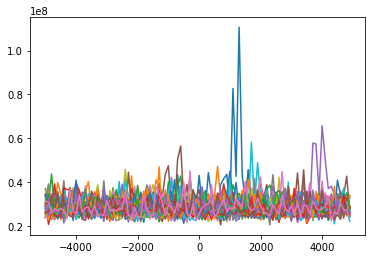

In [36]:
full_data = prn_sweep()

In [37]:
full_data

[[28724304.999999993,
  28548468.00000001,
  33194120.0,
  26038369.999999996,
  31226450.000000004,
  29746024.99999999,
  27853676.999999996,
  28637188.000000004,
  29356239.999999993,
  27065410.0,
  27753554.0,
  28569052.999999996,
  29491733.0,
  28852885.0,
  27417321.000000004,
  28401602.0,
  30625919.999999996,
  24192418.0,
  25461298.0,
  28340112.999999993,
  32878216.999999996,
  24220105.999999996,
  28099025.0,
  25110445.000000004,
  38487553.00000001,
  28092249.999999996,
  29084393.0,
  27165124.999999996,
  26119768.999999996,
  23035924.000000004,
  27624445.0,
  27245384.0,
  27636129.999999996,
  28273231.999999996,
  26092921.0,
  29204872.000000004,
  30127473.000000004,
  32693945.0,
  27578553.999999993,
  24533050.000000004,
  28087824.99999999,
  24762284.999999996,
  26738221.0,
  43266697.99999999,
  26446165.000000007,
  21076669.0,
  29054257.000000004,
  33555994.00000001,
  35264345.00000001,
  26221945.0,
  25417397.0,
  25637989.000000007,
  27633

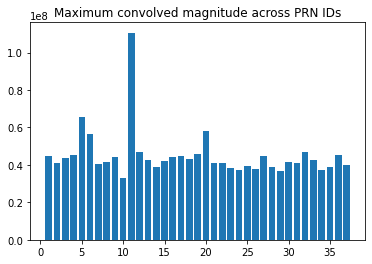

In [42]:
plt.bar(max_amplitudes.keys(), max_amplitudes.values())
plt.title('Maximum convolved magnitude across PRN IDs')
plt.savefig('empirical-satellites.png')